# WiFi triangulation 

- Setup Python development environment
- Install Python package
- Determine the location of a mobile device from RSSI readings and locations of APs given a certain path loss model
- Evaluate the impact of averaging in RSSI
- Visualize the input and output data

## 1. Package ## 
- sys, ianus, numpy, warning, matplotlib, scipy

In [26]:
import sys
import ianus
import numpy as np
import warnings
import math

#Uncomment the following line if you run the python code from a terminal
#import matplot
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

from scipy.optimize import minimize

## 2. Read WiFi and ground truth location data ##

- Y is num_loc-by-3 data array with columns being X, Y, Z coordintes
- X_raw is list of size num_loc, each element is an array of size num_AP x num_scan

In [27]:
# Read WiFi Data

datapath = './dataset/'

X_raw, apinfo = ianus.read_wifi_ap_data(datapath+'wifi.pbf', datapath+'itbap.csv')
Y = ianus.read_location_data(datapath + 'location.pbf')
#print(Y[:,21])
mac_address = list(apinfo.keys())
num_AP = len(mac_address)
num_loc = Y.shape[1]

assert (num_loc == len(X_raw))


## 3. Averaging RSSI readings in each location

In [32]:
##### Get the PL0 value and add to the X_mean
PL0 = np.array(list(apinfo.values()))[:,3]

N = 20 #you should vary this to evaluate its impact on the accuracy


X_mean = np.zeros((num_AP, num_loc))
#Suppress the mean of all NaN warning
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Mean of empty slice')
    for i in range(num_loc):
        num_scans = np.minimum(X_raw[i].shape[1], N)
        X_mean[:,i] = np.nanmean(X_raw[i][:,0:num_scans],axis=1) + PL0
    #print(X_mean[:,70])
        

### 3.1 Heat map of APs

C:\Users\21313\Anaconda3\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


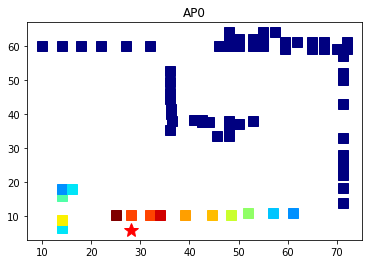

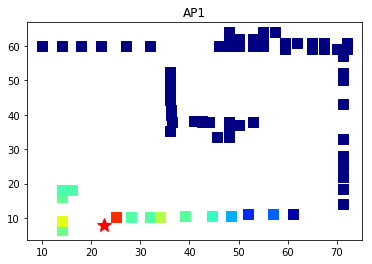

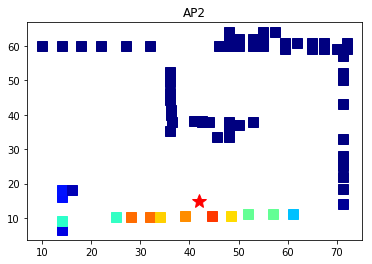

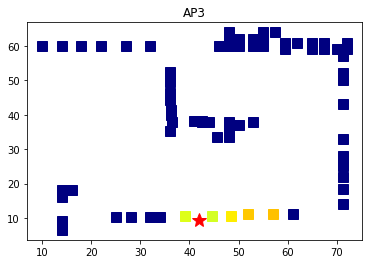

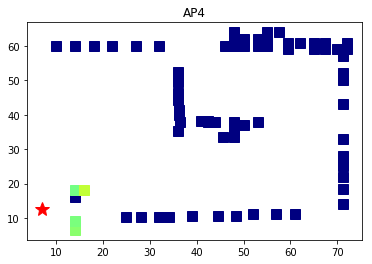

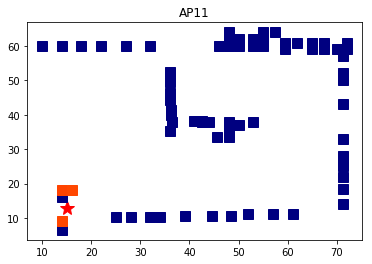

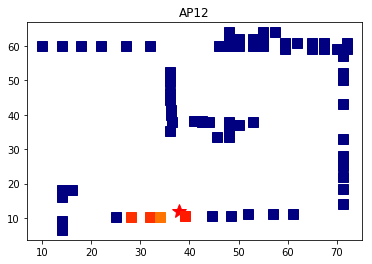

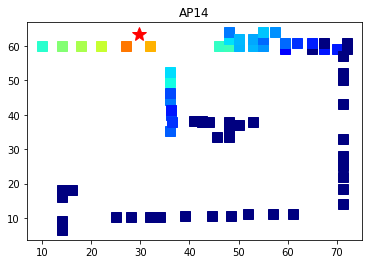

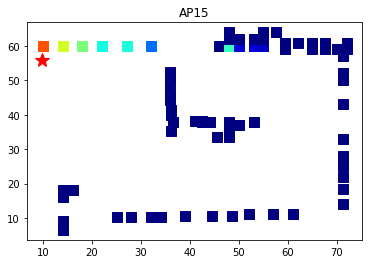

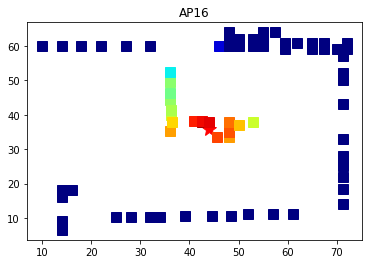

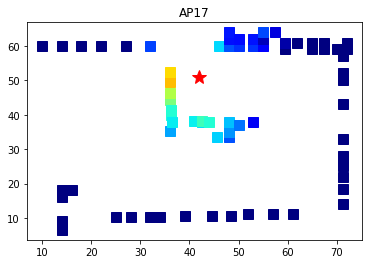

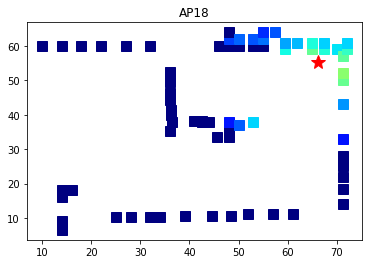

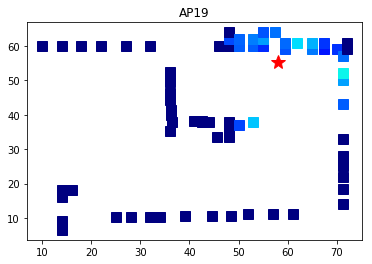

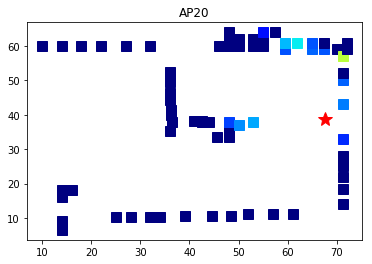

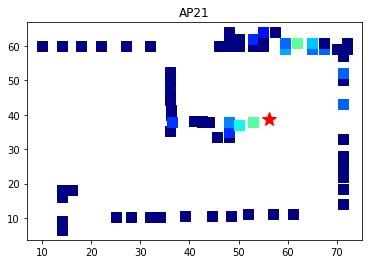

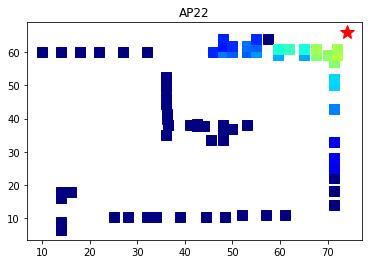

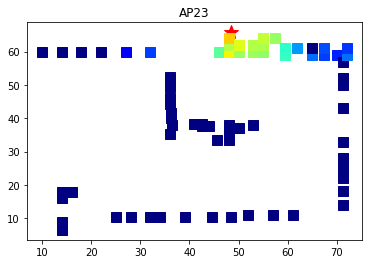

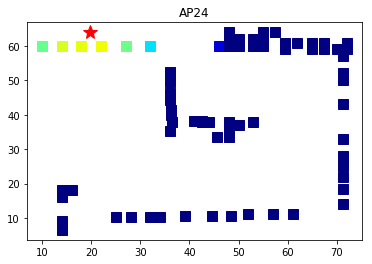

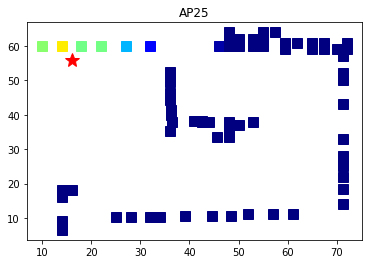

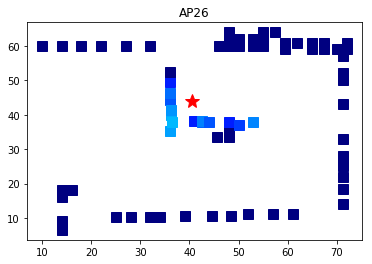

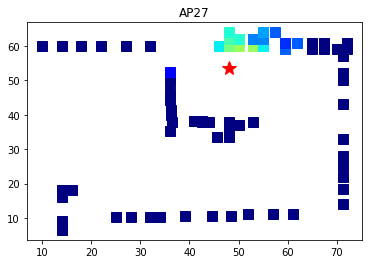

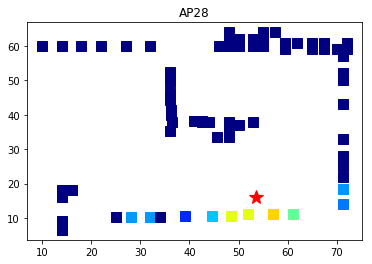

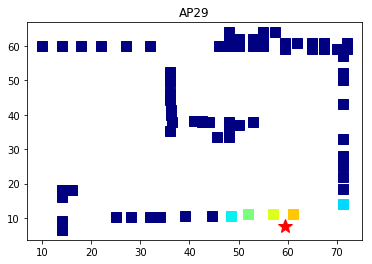

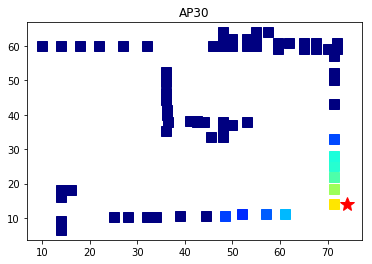

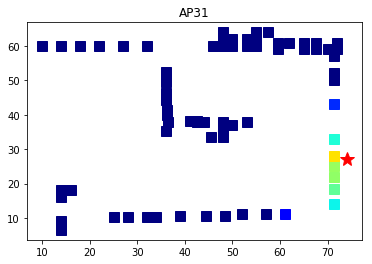

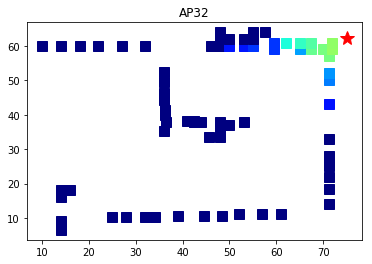

In [38]:
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=np.nanmin(X_mean), vmax=np.nanmax(X_mean))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
plt.close("all")

for ap in range(num_AP):
    if np.sum(np.isnan(X_mean[ap,:])) < X_mean[ap,:].shape:        
        plt.figure()
        plt.title('AP' + str(ap))
        plt.plot(list(apinfo.values())[ap][0], list(apinfo.values())[ap][1], color='r', markersize=15, marker='*')
        for i in range(Y.shape[1]):
            plt.plot(Y[0,i], Y[1,i], color=scalarMap.to_rgba(X_mean[ap, i]), markersize=10, marker='s')
        
        plt.show()

## 4. Trilateration

Use a path-loss model $d \approx 10^{-\frac{P_r[dBm] + PL(d_0) + 40[dBm]}{31.87}}$

### 4.1 Optimization 
The method solves for the location through a (contrained) optimization problem:

$\min_{(x,y,z)}\sum_{i=1}^{i=num\_AP} \left|D(AP_i, (x,y,z)) - d(RSS_i)\right|$

s.t., $x_{min} \le x \le x_{max} \\
y_{min} \le y \le y_{max},\\
z = 1.4$

where $x_{min}, x_{max}, y_{min}, y_{max}$ are boundary conditions, $D(\cdot, \cdot)$ is the Euclidean distance, $d(RSS_i)$ is the distance computed from the path loss model using average RSS with respect to AP $i$. 


In [30]:
#Inferred loctions 
guessed_loc = np.zeros((3,num_loc))
d_RSS = np.zeros((num_AP, num_loc))
AP_loc = list(apinfo.values())
bnds = ((0, 80), (0, 70), (1.4, 1.4))

for i in range(num_AP):
    for j in range(num_loc):
        d_RSS[i, j] = math.pow(10, -(X_mean[i, j] + 40) / 31.87)
        
def cal_distance(AP_loc, guessed_loc):
    distance = 0.0
    distance = math.sqrt(pow(AP_loc[0] - guessed_loc[0], 2.0) + pow(AP_loc[1] - guessed_loc[1], 2.0) + pow(AP_loc[2] - guessed_loc[2], 2.0))
    return distance

def mse(x, AP_loc, d_RSS):
    mse = 0.0
    for ap in range(num_AP):
        if  math.isnan(d_RSS[ap]):
            continue
        distance = cal_distance(AP_loc[ap], x)
        mse += math.pow(distance - d_RSS[ap], 2.0)
    return mse

for i in range(num_loc):
    result = minimize(mse, [0, 0, 1.4], args=(AP_loc, d_RSS[:,i]), method='L-BFGS-B', bounds=bnds)
    guessed_loc[0,i] = (result.x)[0]
    guessed_loc[1,i] = (result.x)[1]
    guessed_loc[2,i] = (result.x)[2]



### 4.2 Visualization data

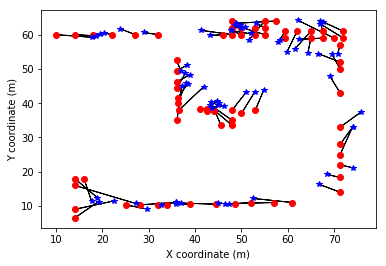

In [31]:
plt.plot(Y[0,:], Y[1,:], 'ro')
plt.plot(guessed_loc[0,:], guessed_loc[1,:], 'b*')
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordinate (m)')
for i in range(Y.shape[1]):
    plt.arrow(Y[0,i], Y[1,i], guessed_loc[0,i]-Y[0,i], guessed_loc[1,i]-Y[1,i])

plt.show()

5.19282848428


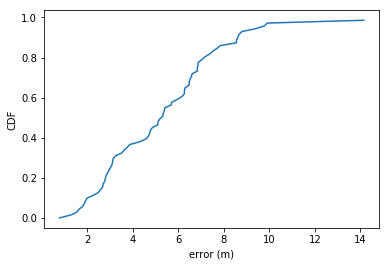

In [100]:
errors = np.zeros(num_loc)
for i in range(num_loc):
    errors[i] = math.sqrt(pow(Y[0,i] - guessed_loc[0, i], 2) + pow(Y[1,i] - guessed_loc[1, i],2))

mean = np.nanmean(errors)
print(mean)
errors_new = np.sort(errors)
F = np.array(range(num_loc))/float(num_loc)
plt.plot(errors_new, F)
plt.xlabel('error (m)')
plt.ylabel('CDF')
plt.show()



